In [1]:
import tskit
import tszip
import numpy as np
import pandas as pd
import stdpopsim
from numpy.random import default_rng
import msprime
import pyreadr
import os

In [46]:
pyreadr.__version__

'0.4.2'

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [3]:
BCFTOOLS = "/home/kele/programs/bcftools/bcftools-1.11/bcftools"

## 3 population paths

In [47]:
n_anc=3
base_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/MOSAIC/la_probabilites.RData"
bmixpath = '/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/short_run/bmix/bmix.anc.vcf.gz'

In [4]:
n_anc=3
base_path = "/home/kele/3pop_c/SUMMARY"
true_path = "/home/kele/3pop_c/true_local_ancestry.site_matrix.npz"
rf_fb_path = '/home/kele/3pop_c/RFMix2/rfmix2.fb.tsv'
mosaic_path = "/home/kele/3pop_c/MOSAIC/la_probs.RData"
bmixpath = '/home/kele/3pop_c/bmix/bmix.anc.vcf.gz'

## 4 population paths

In [48]:
n_anc=4
base_path = "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/SUMMARY"
true_path = "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/true_local_ancestry.site_matrix.npz"
rf_fb_path =  "/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/RFMix2/rfmix2.fb.tsv"
mosaic_path = '/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/MOSAIC/la_probs.RData'
bmixpath = '/home/kele/Documents/lai/lai-sim/results/OutOfAfrica_4J17/4pop_79/4pop_test/bmix/bmix.anc.vcf.gz'

# TODO
    - move to Snakemake
    - write out the diploid ancestry dosage matrices
    - write out the accuracy for each in a file

In [5]:
def get_ancestry_dosage(arr, n_anc):
    anc_dosage = np.zeros((arr.shape[0], int(arr.shape[1]/2)), dtype=np.half)
    if n_anc==3:
        assert (n_anc==3)
        a0 = arr[:, 0::3] # should be views
        a1 = arr[:, 1::3]
        a2 = arr[:, 2::3]
        anc_dosage[:, 0::3] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::3] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::3] = a2[:, ::2] + a2[:, 1::2]
    elif n_anc==4:
        assert (n_anc==4)
        a0 = arr[:, 0::4] # should be views
        a1 = arr[:, 1::4]
        a2 = arr[:, 2::4]
        a3 = arr[:, 3::4]
        anc_dosage[:, 0::4] = a0[:, ::2] + a0[:, 1::2]
        anc_dosage[:, 1::4] = a1[:, ::2] + a1[:, 1::2]
        anc_dosage[:, 2::4] = a2[:, ::2] + a2[:, 1::2]
        anc_dosage[:, 3::4] = a3[:, ::2] + a3[:, 1::2]   
    return anc_dosage

In [6]:
def r2_ancestry_dosage(true_dosage, pred_dosage, n_anc):
    per_anc = []
    for i in range(n_anc):
        per_anc.append(
            r2_score(
                y_true=true_dosage[:,i::n_anc].ravel(),
                y_pred=pred_dosage[:,i::n_anc].ravel()
            )
        )
    per_ind = []
    for i in range(int(true_dosage.shape[1]/n_anc)):
        per_ind.append(
            r2_score(
                y_true=true_dosage[:, i*n_anc:i*n_anc+n_anc].ravel(),
                y_pred=pred_dosage[:, i*n_anc:i*n_anc+n_anc].ravel()
            )
        )
    
    return(per_anc, per_ind)

# True ancestry

In [7]:
def load_true_la(path):
    return np.load(path)['arr']

def get_true_anc_dosage(true_la, n_anc):
    hap1 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    hap2 = np.zeros((true_la.shape[0], int(true_la.shape[1]/2*n_anc)), dtype = 'int8')
    aa = np.arange(true_la[:, ::2].shape[1])*n_anc+true_la[:, ::2]
    bb = np.arange(true_la[:, 1::2].shape[1])*n_anc+true_la[:, 1::2]
    np.put_along_axis(hap1, aa, 1, axis=1)
    np.put_along_axis(hap2, bb, 1, axis=1)
    return hap1+hap2

## Load in the probablistic output of each method
Data frame with one row per site, 

Only every 5 sites represented in this file - not sure if it will always be intervals of 5 sites

After the index columns - each (individual) X (haplotype) X (population) has an entry. 

In [8]:
def load_rfmix_fb(path):
    rfmix_res = pd.read_csv(path, sep='\t', comment='#')
    # expand out to each site
    rfmix_res = np.repeat(rfmix_res.iloc[:, 4:].values, [5], axis = 0)
    return rfmix_res

In [9]:
def load_bmix(path):
    csv_path = path.replace('.vcf.gz', '.csv')
    !{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {path} > {csv_path}
    bmix = pd.read_csv(csv_path, header=None)
    bmix = bmix.dropna(axis=1)
    return(bmix.iloc[:,2:].values)

In [10]:
def load_mosaic(path):
    mr = pyreadr.read_r(path)['arr'].astype(np.half)
    mr = mr.to_numpy().T.reshape((mr.shape[2],-1), order='C')
    return mr

In [11]:
true_anc_dosage = get_true_anc_dosage(load_true_la(true_path), n_anc=n_anc)
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)


In [13]:
len(true_anc_dosage), len(rfmix_anc_dosage)

(383632, 383635)

In [14]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage[:len(true_anc_dosage)],
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.9653875447483656,
 [0.9723503192645575, 0.957936253898807, 0.9658760610817325])

## Why is mosaic failing

In [15]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)


LibrdataError: Unable to read from file

In [18]:
!ls -l {mosaic_path}

-rw-r--r-- 1 kele kele 141394573 Oct 29 04:41 /home/kele/3pop_c/MOSAIC/la_probs.RData


In [29]:
import glob 
mosaic_path = glob.glob('/home/kele/Documents/lai/lai-sim/results/*/*/*/MOSAIC/*.RData')[1]
#pyreadr.read_r(mosaic_path)

In [30]:
#load_mosaic(mosaic_path)

In [31]:
!ls /home/kele/3pop_c/MOSAIC/*.RData

/home/kele/3pop_c/MOSAIC/admixed_3way_1-400_22-22_3200_60_0.99_100.RData
/home/kele/3pop_c/MOSAIC/admixed.RData
/home/kele/3pop_c/MOSAIC/la_probs.RData
/home/kele/3pop_c/MOSAIC/localanc_admixed_3way_1-400_22-22_3200_60_0.99_100.RData
/home/kele/3pop_c/MOSAIC/localanc_admixed.RData


In [ ]:
# run in R
library('MOSAIC')

model_results = '/home/kele/3pop_c/MOSAIC/admixed.RData'
la_results = '/home/kele/3pop_c/MOSAIC/localanc_admixed.RData'
mosaic_input_dir = '/home/kele/3pop_c/MOSAIC/input/'

load(model_results)
load(la_results)
# localanc gives the local ancestry at each grid point
# get local ancestry probabilities at each SNP
local_pos=grid_to_pos(localanc, mosaic_input_dir, g.loc, chrnos)
dims = dim(local_pos[[1]])
# convert to array and then export
arr = array(unlist(local_pos, use.names=FALSE), dims)

In [ ]:
arr2 = array(unlist(local_pos, use.names=FALSE), dims)

In [32]:
output_path = '/home/kele/3pop_c/MOSAIC/la_probs2.RData'
save(arr, file = output_path)
#save(arr, file = simple_output)

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (2673326820.py, line 11)

In [48]:
#pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs2.RData', use_objects=['arr'])
pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs.rds')

LibrdataError: Unable to read from file

In [39]:
pyreadr.read_r('/home/kele/Documents/lai/lai-sim/results/AmericanAdmixture_4B11/AA_42/3pop_5/MOSAIC/la_probs.RData')


OrderedDict([('arr',
              <xarray.DataArray (dim_0: 3, dim_1: 400, dim_2: 100000)>
              array([[[2.87565605e-04, 2.87565605e-04, 2.87565605e-04, ...,
                       9.99998876e-01, 9.99998876e-01, 9.99998876e-01],
                      [3.15267736e-04, 3.15267736e-04, 3.15267736e-04, ...,
                       3.14384451e-04, 3.14384451e-04, 3.14384451e-04],
                      [3.80432148e-05, 3.80432148e-05, 3.80432148e-05, ...,
                       9.99874816e-01, 9.99874816e-01, 9.99874816e-01],
                      ...,
                      [9.97744943e-01, 9.97744943e-01, 9.97744943e-01, ...,
                       2.07995807e-07, 2.07995807e-07, 2.07995807e-07],
                      [2.01904871e-08, 2.01904871e-08, 2.01904871e-08, ...,
                       1.49554377e-07, 1.49554377e-07, 1.49554377e-07],
                      [2.07533090e-04, 2.07533090e-04, 2.07533090e-04, ...,
                       2.48882211e-07, 2.48882211e-07, 2.48882211

In [35]:
pyreadr.read_r('/home/kele/3pop_c/MOSAIC/la_probs2.RData', use_objects=['arr'])

LibrdataError: Unable to read from file

In [14]:
true_anc_dosage

array([[0, 2, 0, ..., 1, 0, 1],
       [0, 2, 0, ..., 1, 0, 1],
       [0, 2, 0, ..., 1, 0, 1],
       ...,
       [0, 0, 2, ..., 0, 1, 1],
       [0, 0, 2, ..., 0, 1, 1],
       [0, 0, 2, ..., 0, 1, 1]], dtype=int8)

In [28]:
bb = load_true_la(true_path)
bb.shape

(383632, 800)

In [29]:
!wc -l /home/kele/3pop_c/site.positions


383632 /home/kele/3pop_c/site.positions


In [26]:
aa

,chromosome,physical_position,genetic_position,genetic_marker_index,pop_3-ind_0001:::hap1:::pop_0,pop_3-ind_0001:::hap1:::pop_1,pop_3-ind_0001:::hap1:::pop_2,pop_3-ind_0001:::hap2:::pop_0,pop_3-ind_0001:::hap2:::pop_1,pop_3-ind_0001:::hap2:::pop_2,...,pop_3-ind_0399:::hap1:::pop_2,pop_3-ind_0399:::hap2:::pop_0,pop_3-ind_0399:::hap2:::pop_1,pop_3-ind_0399:::hap2:::pop_2,pop_3-ind_0400:::hap1:::pop_0,pop_3-ind_0400:::hap1:::pop_1,pop_3-ind_0400:::hap1:::pop_2,pop_3-ind_0400:::hap2:::pop_0,pop_3-ind_0400:::hap2:::pop_1,pop_3-ind_0400:::hap2:::pop_2
0,chr22,12,0.00002,0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,chr22,603,0.00087,5,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,chr22,1494,0.00216,10,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,chr22,2972,0.00429,15,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,chr22,3152,0.00455,20,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76722,chr22,51300955,74.10435,383610,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
76723,chr22,51301994,74.10585,383615,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
76724,chr22,51302310,74.10630,383620,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
76725,chr22,51303136,74.10750,383625,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [12]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)


In [19]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)


LibrdataError: Unable to read from file

In [13]:
true_anc_dosage.shape, rfmix_anc_dosage.shape

((383632, 1200), (383635, 1200))

In [20]:
383632

383632

In [106]:
rfmix_anc_dosage = get_ancestry_dosage(load_rfmix_fb(rf_fb_path), n_anc=n_anc)
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    n_anc=n_anc
)
np.mean(rfmix_anc_r2), rfmix_anc_r2

(0.8689694318621795,
 [0.9805804670046059,
  0.9378287527910344,
  0.7520133593010468,
  0.8054551483520305])

In [107]:
mosaic_anc_dosage = get_ancestry_dosage(load_mosaic(mosaic_path), n_anc=n_anc)
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    n_anc=n_anc
)
np.mean(mosaic_anc_r2), mosaic_anc_r2

(0.9373550244573435,
 [0.9764352329082557,
  0.9524854629874562,
  0.8993502406093475,
  0.9211491613243146])

In [108]:
bmix_anc_dosage = get_ancestry_dosage(load_bmix(bmixpath), n_anc)
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    n_anc=n_anc
)
np.mean(bmix_anc_r2), bmix_anc_r2

(0.9492861393594592,
 [0.984985616648701,
  0.966726598305069,
  0.9110724968955656,
  0.9343598455885012])

In [68]:
def plot_ancestry_dosage(pred_dosage, start_index, n_anc, reference_dosage=None):
    """
    only works for 3 ancestries
    """
    colors = ['blue', 'orange', 'green', 'grey']
    
    fig, ax = plt.subplots(figsize = (12, n_anc*1.5), nrows=n_anc, sharex=True, sharey=True)
    
    
    f = []
    for i in range(n_anc):
        l, = ax[i].plot(pred_dosage[:, start_index+i], c=colors[i])
        f.append(l)
        
    plt.legend(f, [f'pop{p}' for p in range(n_anc)])
    
    if reference_dosage is not None:
        l, = ax[i].plot(reference_dosage[:, start_index+i], c=colors[i], alpha=.3, ls='--')

    fig.tight_layout()
    sns.despine(bottom=True)
    ax[0].set_title('Ancestry dosage')
    ax[-1].set_xlabel('Site number ')

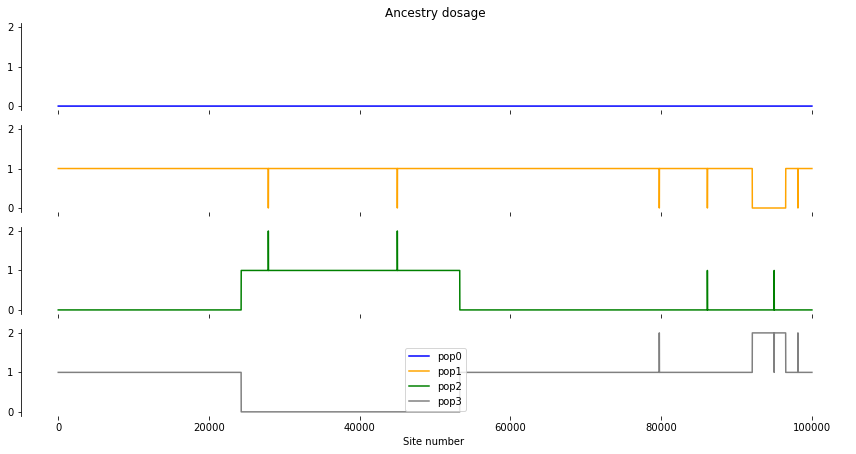

In [69]:
plot_ancestry_dosage(true_anc_dosage, start_index=0, n_anc=4, reference_dosage=None)

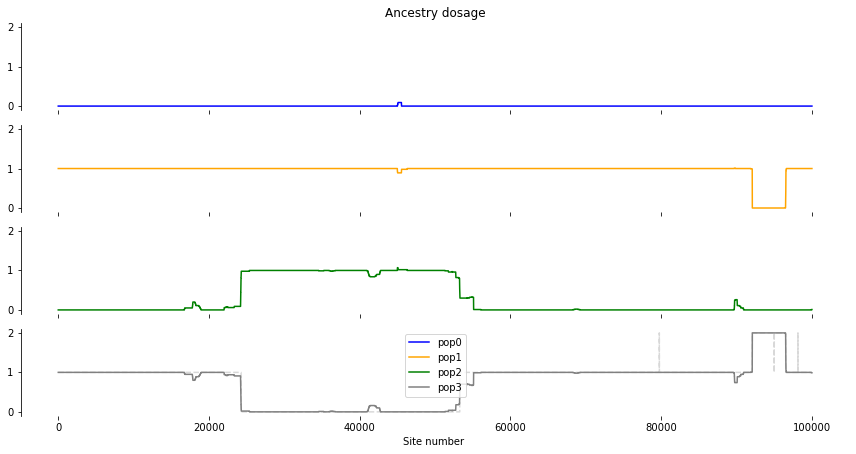

In [70]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=0, n_anc=4, reference_dosage=true_anc_dosage)

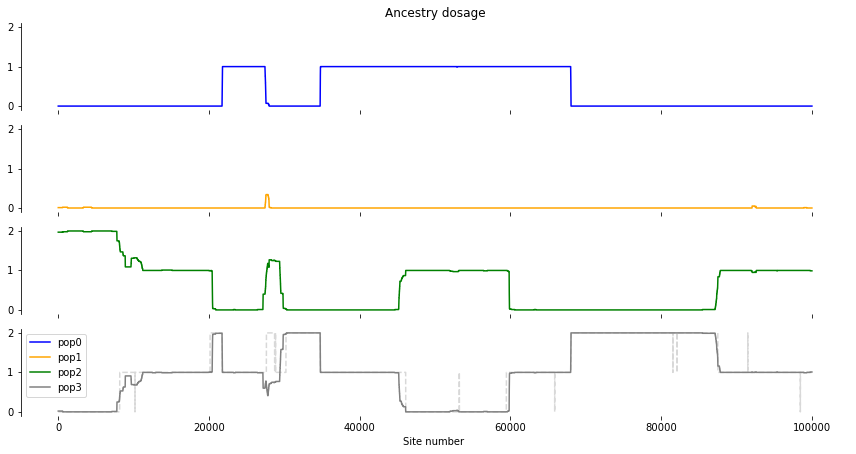

In [71]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=4, n_anc=4, reference_dosage=true_anc_dosage)

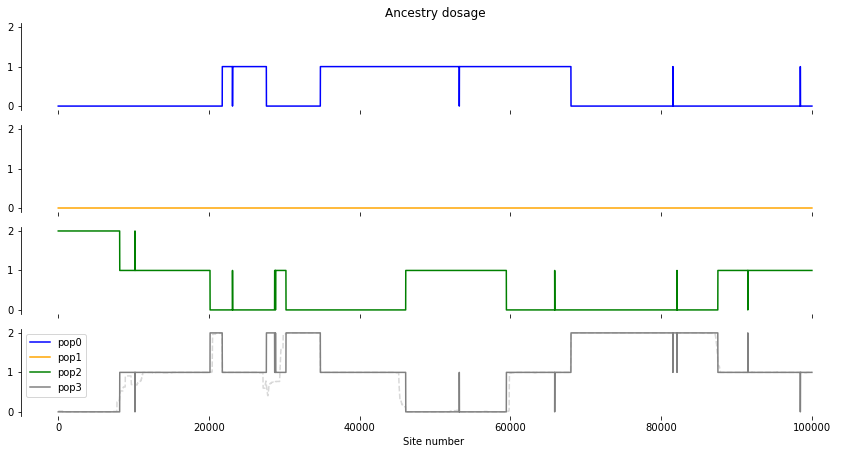

In [93]:
plot_ancestry_dosage(true_anc_dosage , start_index=4, n_anc=4, reference_dosage=bmix_anc_dosage)

In [87]:
sqdif = ((true_anc_dosage - bmix_anc_dosage).astype('float')**2).sum().sum()

In [92]:
sqdif/ (true_anc_dosage.shape[0]*true_anc_dosage.shape[1])

0.020697263222672273

In [94]:
np.sqrt(sqdif/(true_anc_dosage.shape[0]*true_anc_dosage.shape[1]))

0.14386543442631478

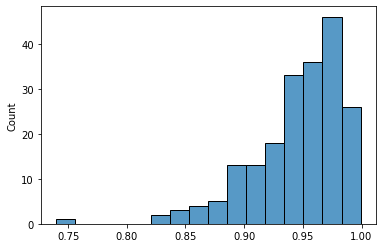

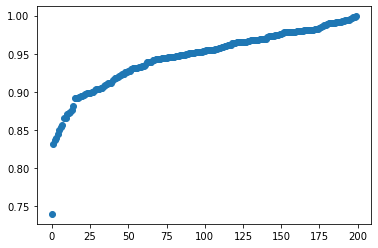

(0.9484972800495047, 0.9458628410155053)

In [96]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
plt.show()
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

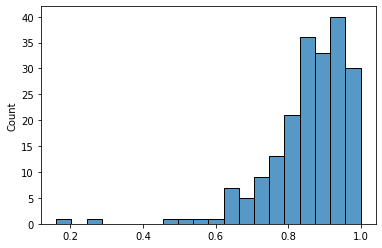

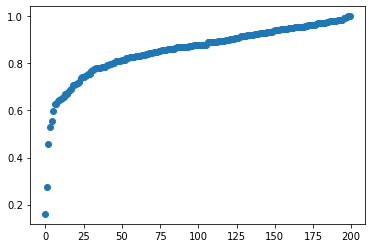

(0.8615184523412318, 0.8554434306577632)

In [95]:
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

In [58]:
## Write R2 tables
with open(os.path.join(base_path, 'R2_score.ancestry.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'anc_{x}' for x in range(nanc)]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_anc_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_anc_r2])  + '\n')
    
with open(os.path.join(base_path, 'R2_score.individuals.tsv'), 'w') as OUTFILE:
    OUTFILE.write('\t'.join(['method'] + [f'ind_{x}' for x in range(len(bmix_ind_r2))]) + '\n')
    OUTFILE.write('\t'.join(['rfmix2'] + [str(x) for x in rfmix_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['mosaic'] + [str(x) for x in mosaic_ind_r2])  + '\n')
    OUTFILE.write('\t'.join(['bmix'] + [str(x) for x in bmix_ind_r2])  + '\n')

In [ ]:
assert False

[0.974887791486827, 0.9576812785319607, 0.9656232198425216]

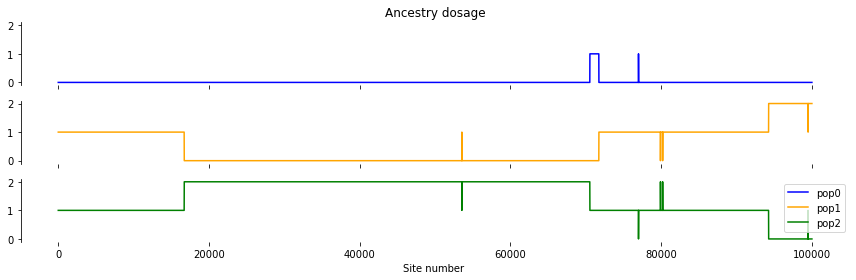

In [10]:
plot_ancestry_dosage(true_anc_dosage, start_index=3, reference_dosage=None)

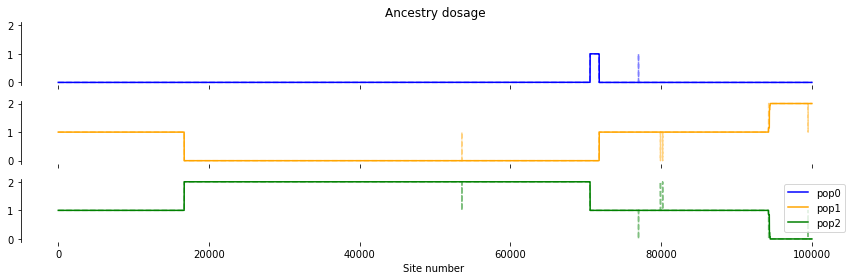

In [14]:
plot_ancestry_dosage(rfmix_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

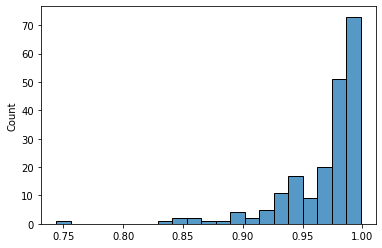

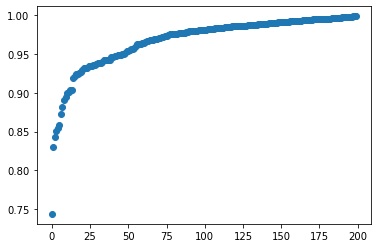

(0.9660640966204364, 0.9674451863592934)

In [15]:
rfmix_anc_r2, rfmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=rfmix_anc_dosage,
    nanc=3
)
sns.histplot(rfmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(rfmix_ind_r2)), sorted(rfmix_ind_r2))
plt.show()
np.mean(rfmix_anc_r2), np.mean(rfmix_ind_r2)

# Mosaic
Data frame with one row per site. 
after the index columns - each (individual) X (haplotype) X (ancestry) has an entry. 

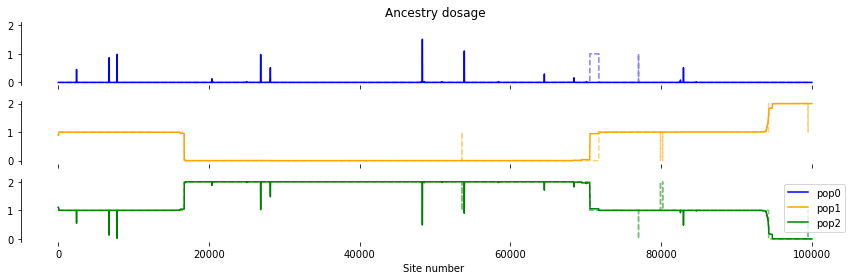

In [35]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=3, reference_dosage=true_anc_dosage)

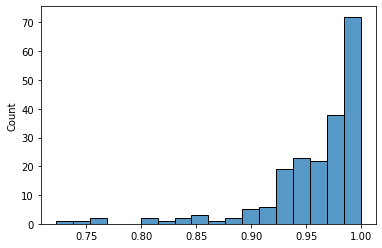

(0.9527561151967023, 0.9574373895594066)

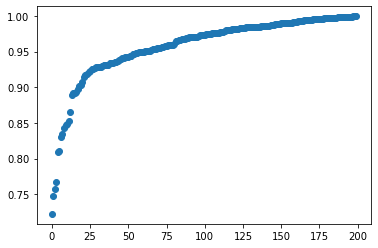

In [18]:
mosaic_anc_r2, mosaic_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=mosaic_anc_dosage,
    nanc=3
)
sns.histplot(mosaic_ind_r2)
plt.show()
plt.scatter(np.arange(len(mosaic_ind_r2)), sorted(mosaic_ind_r2))
np.mean(mosaic_anc_r2), np.mean(mosaic_ind_r2)

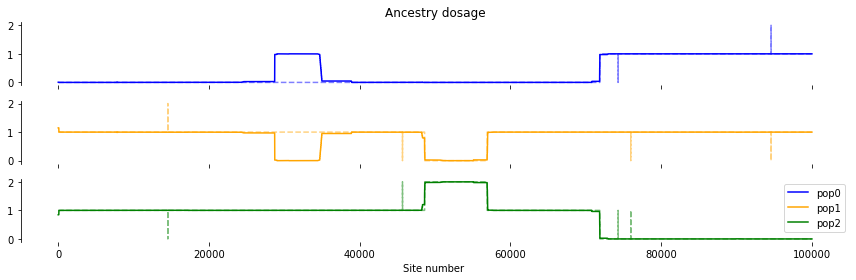

In [19]:
plot_ancestry_dosage(mosaic_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

# bmix

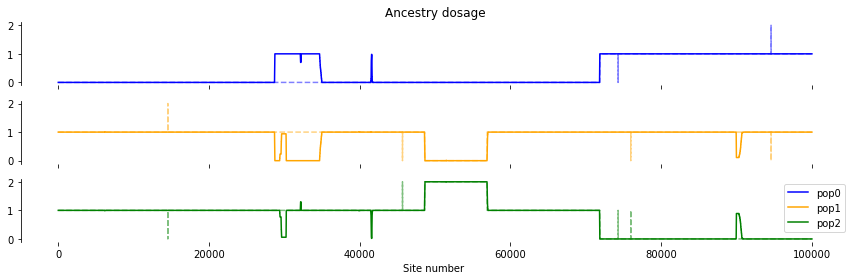

In [38]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

In [21]:
!{BCFTOOLS} query -f '%CHROM, %POS, [%ANP1, %ANP2,]\n' {bmixpath} > {bmixpath.replace('.vcf.gz', '.csv')}

In [22]:
bmix = pd.read_csv(bmixpath.replace('.vcf.gz', '.csv'), header = None)
bmix = bmix.dropna(axis=1)
bmix = bmix.iloc[:,2:]
bmix_anc_dosage = get_ancestry_dosage(bmix.values)

In [23]:
bmix_anc_r2, bmix_ind_r2 = r2_ancestry_dosage(
    true_dosage=true_anc_dosage, 
    pred_dosage=bmix_anc_dosage,
    nanc=3
)
np.mean(bmix_anc_r2), np.mean(bmix_ind_r2)

(0.9788792486156549, 0.9797811616797916)

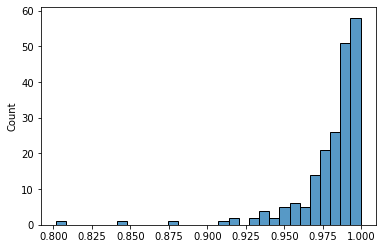

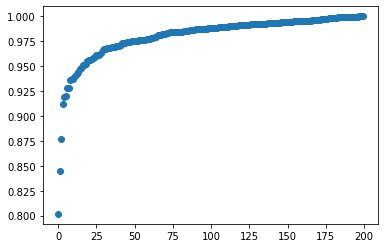

In [24]:
sns.histplot(bmix_ind_r2)
plt.show()
plt.scatter(np.arange(len(bmix_ind_r2)), sorted(bmix_ind_r2))
np.where(bmix_ind_r2 == np.min(bmix_ind_r2))
plt.show()

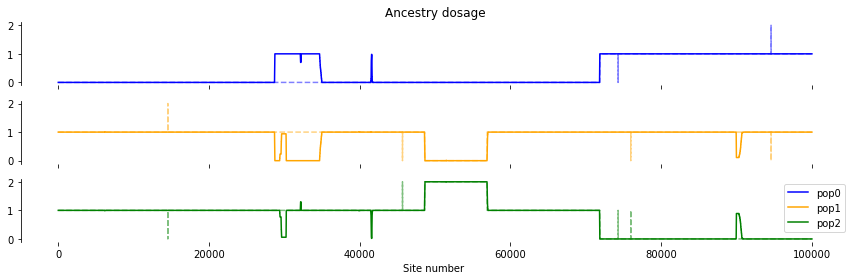

In [25]:
plot_ancestry_dosage(bmix_anc_dosage, start_index=62*3, reference_dosage=true_anc_dosage)

## There is not a huge correlation in the indiviudal level accuracy of the various methods here

In [26]:
r2_df = pd.DataFrame(data = {'bmix':bmix_ind_r2, 'rfmix':rfmix_ind_r2, 'mosaic':mosaic_ind_r2})

In [27]:
pearsonr(r2_df['bmix'], r2_df['mosaic'])[0]**2, pearsonr(r2_df['bmix'], r2_df['rfmix'])[0]**2, pearsonr(r2_df['mosaic'], r2_df['rfmix'])[0]**2

(0.08360726201928743, 0.3831561831675088, 0.1638570657100257)

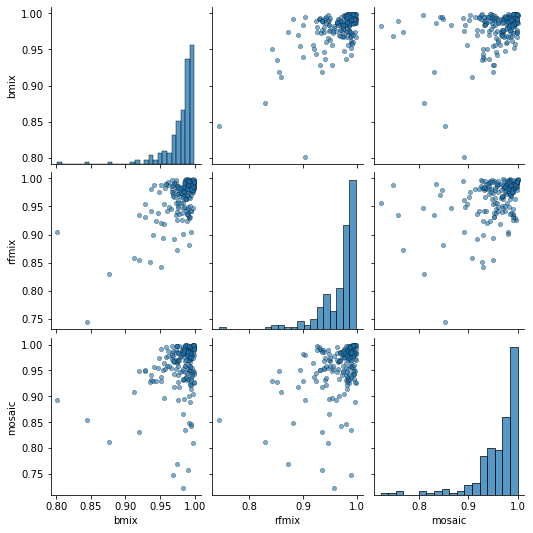

In [28]:
sns.pairplot(r2_df,
             plot_kws = {'alpha': 0.6, 's': 20, 'edgecolor': 'k'})

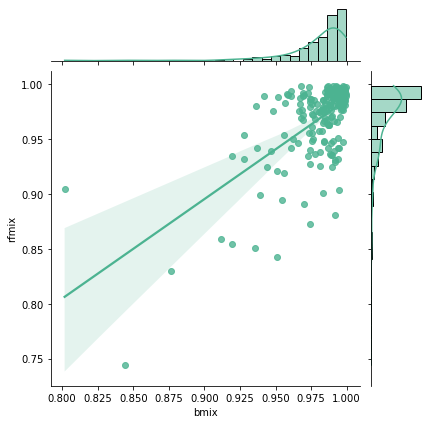

In [29]:
sns.jointplot(data = r2_df, x='bmix', y='rfmix', color="#4CB391", kind="reg")

In [ ]:
def plot_ancestry_dosage(pred_dosage, start_index, n_anc, reference_dosage=None):
    """
    only works for 3 ancestries
    """
    fig, ax = plt.subplots(figsize = (12, n_anc*1.5), nrows=n_anc, sharex=True, sharey=True)
    
    l0, = ax[0].plot(pred_dosage[:, start_index+0], c='b')
    l1, = ax[1].plot(pred_dosage[:, start_index+1], c='orange')
    l2, = ax[2].plot(pred_dosage[:, start_index+2], c='green')
    
    plt.legend([l0, l1, l2], ['pop0', 'pop1', 'pop2'])

    
    if reference_dosage is not None:
        l0, = ax[0].plot(reference_dosage[:, start_index+0], c='b', alpha=.5, ls='--')
        l1, = ax[1].plot(reference_dosage[:, start_index+1], c='orange', alpha=.5, ls='--')
        l2, = ax[2].plot(reference_dosage[:, start_index+2], c='green', alpha=.5, ls='--')

    fig.tight_layout()
    sns.despine(bottom=True)
    ax[0].set_title('Ancestry dosage')
    ax[-1].set_xlabel('Site number ')